In [13]:
from voxelmorph.tf.losses import NCC
import os
import numpy as np
import keras.backend as K
import tensorflow as tf
import nibabel as nib
from glob import glob
from voxelmorph.tf.networks import AIRNet
from tqdm import tqdm_notebook as tqdm

import matplotlib.pyplot as plt
plt.set_cmap('gray')
plt.rcParams['figure.figsize'] = (10, 8)

os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "4"

def calc_ncc(img1, img2):
    if img1.ndim == 3:
        img1 = img1[None, ...]
    if img2.ndim == 3:
        img2 = img2[None, ...]
    ncc_loss = NCC()
    ip1 = K.constant(img1)
    ip2 = K.constant(img2)
    ncc_val = ncc_loss.loss(ip1, ip2)
    return K.eval(ncc_val)

def process_brats(img_vol):
    img_vol = np.rot90(img_vol.transpose(2, 0, 1), axes=(1, 2), k=3)
    img_vol = img_vol / img_vol.mean()
    img_vol = np.interp(img_vol, (img_vol.min(), img_vol.max()), (0, 1))
    img_vol = img_vol[13:-14]
    img_vol = np.pad(img_vol, pad_width=[(0, 0), (8, 8), (8, 8)], mode='constant', constant_values=0)
    return img_vol

def get_brats_pair(fpath_brats, case_num):
    t1pre = nib.load('{}/{}/{}_t1.nii.gz'.format(fpath_brats, case_num, case_num)).get_fdata()
    t1ce = nib.load('{}/{}/{}_t1ce.nii.gz'.format(fpath_brats, case_num, case_num)).get_fdata()
    return process_brats(t1pre), process_brats(t1ce)

<Figure size 720x576 with 0 Axes>

In [3]:
case = 'BraTS2021_00006'
fpath_affn = '/home/srivathsa/projects/studies/gad/vmorph/data/brats/val'
fpath_brats = '/home/srivathsa/projects/brats_2021/data/val'

In [14]:
imgs1 = []
imgs2 = []

fpaths = sorted(glob('/home/srivathsa/projects/studies/gad/vmorph/data/brats/val/*.npz'))

for fpath_affn in tqdm(fpaths, total=len(fpaths)):
    data_affn = np.load(fpath_affn)['data']
    imgs1.append(data_affn[0])
    imgs2.append(data_affn[1])
imgs1 = np.array(imgs1)
imgs2 = np.array(imgs2)
ncc_affn = calc_ncc(imgs1, imgs2)
print(ncc_affn)

/home/srivathsa/miniconda3/envs/voxelmorph/lib/python3.7/site-packages/ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


  0%|          | 0/125 [00:00<?, ?it/s]

ValueError: Cannot create a tensor proto whose content is larger than 2GB.

In [5]:
img1, img2 = get_brats_pair(fpath_brats, case)
ncc_preg = calc_ncc(img1, img2)
print(ncc_preg)

-0.89007765


In [41]:
airnet = AIRNet(inshape=(128, 256, 256))
airnet.model.load_weights('/home/srivathsa/projects/studies/gad/vmorph/runs/20211006_212811-brats/ckps/0150.h5')
pred = airnet.model.predict([data_affn[1][None, ..., None], data_affn[0][None, ..., None]])
img2_reg = pred[0, ..., 0]

Model: "model_6"
______________________________________________________________________________________________________________
Layer (type)                        Output Shape            Param #      Connected to                         
airnet_source_input (InputLayer)    (None, 128, 256, 256, 1 0                                                 
______________________________________________________________________________________________________________
airnet_target_input (InputLayer)    (None, 128, 256, 256, 1 0                                                 
______________________________________________________________________________________________________________
pre_conv (Conv3D)                   (None, 128, 256, 256, 1 144          airnet_source_input[0][0]            
                                                                         airnet_target_input[0][0]            
_______________________________________________________________________________________________

                                                                         mpool_db_tr_4[1][0]                  
                                                                         conv_db_5_0[1][0]                    
                                                                         conv_db_5_1[1][0]                    
                                                                         conv_db_5_2[1][0]                    
                                                                         conv_db_5_3[1][0]                    
                                                                         conv_db_5_4[1][0]                    
                                                                         conv_db_5_5[1][0]                    
                                                                         conv_db_5_6[1][0]                    
                                                                         conv_db_5_7[1][0]                    
 

In [43]:
ncc_pred = calc_ncc(img1, img2)
print(ncc_pred)

-0.9235035


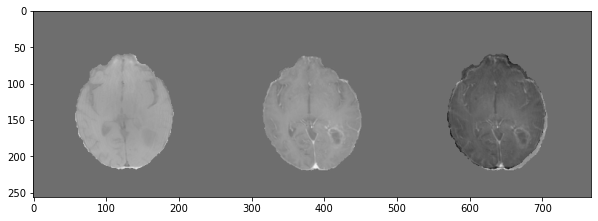

In [6]:
idx = 64
sl1 = data_affn[0, idx]
sl2 = data_affn[1, idx]
diff = sl2 - sl1
plt.imshow(np.hstack([sl1, sl2, diff]))

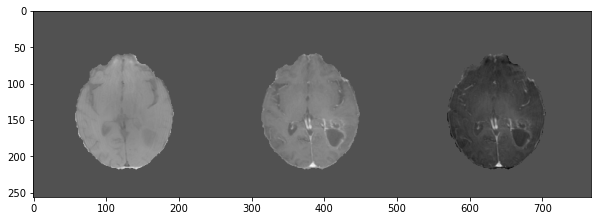

In [7]:
sl1 = img1[idx]
sl2 = img2[idx]
diff = sl2 - sl1
plt.imshow(np.hstack([sl1, sl2, diff]))

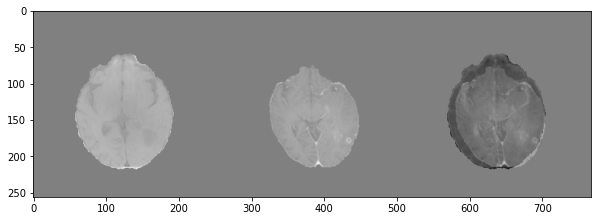

In [40]:
sl1 = img1[idx]
sl2 = img2_reg[idx]
diff = sl2 - sl1
plt.imshow(np.hstack([sl1, sl2, diff]))